In [3]:
import jax
import jax.numpy as jnp
import jax.random as random
import numpyro
import numpyro.distributions as dist
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

(-3.0, 8.0)

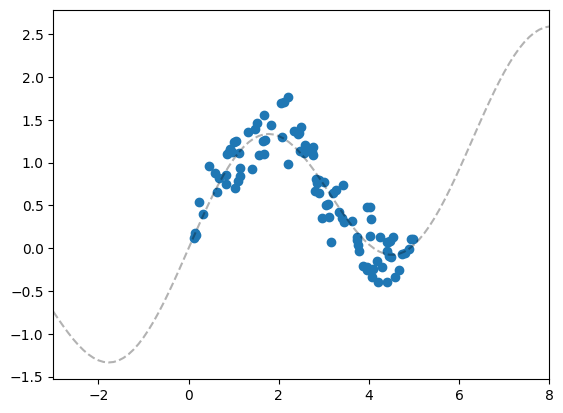

In [47]:
true_function = lambda x: jnp.sin(x) + 0.2 * x
N = 100
x = jnp.sort(random.uniform(random.PRNGKey(0), (N,), minval=0, maxval=5))
y = true_function(x) + random.normal(random.PRNGKey(1), (N,)) * 0.2
plt.scatter(x, y)
linspace = jnp.linspace(-3, 8, 100)
plt.plot(linspace, true_function(linspace), "--", color="black", alpha=0.3, label="True function")
plt.xlim(-3, 8)

In [50]:
def model(x, y=None):
    # Priors
    a = numpyro.sample("a", dist.Normal(0, 10))
    b = numpyro.sample("b", dist.Normal(0, 10))
    c = numpyro.sample("c", dist.Normal(0, 1))
    d = numpyro.sample("d", dist.Normal(0, 1))
    e = numpyro.sample("e", dist.Normal(0, 0.1))
    f = numpyro.sample("f", dist.Normal(0, 0.1))
    beta = numpyro.sample("beta", dist.LogNormal(0, 1))
    with numpyro.plate("data", x.shape[0]):
        # Likelihood
        y_mean = jnp.array([a, b, c, d, e, f]) @ jnp.array([x**5,x**4, x**3, x**2, x, jnp.ones_like(x)])
        numpyro.deterministic("y_mean", y_mean)
        numpyro.sample("y", dist.Normal(y_mean, 1/beta), obs=y)

# Inference
kernel = numpyro.infer.NUTS(model)
mcmc = numpyro.infer.MCMC(kernel, num_warmup=500, num_samples=1000)
mcmc.run(random.PRNGKey(2), x=x, y=y)
mcmc.print_summary()
samples = mcmc.get_samples()

sample: 100%|██████████| 1500/1500 [00:21<00:00, 68.41it/s, 1023 steps of size 1.17e-03. acc. prob=0.91]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a     -0.01      0.00     -0.01     -0.02     -0.01     86.93      1.01
         b      0.21      0.04      0.22      0.15      0.27     80.60      1.01
      beta      4.50      0.32      4.50      3.98      5.01    261.60      1.00
         c     -1.03      0.14     -1.04     -1.25     -0.78     75.73      1.02
         d      1.58      0.21      1.61      1.25      1.91     70.99      1.03
         e      0.08      0.10      0.08     -0.07      0.25     71.76      1.05
         f      0.17      0.06      0.17      0.06      0.27     96.06      1.00

Number of divergences: 0


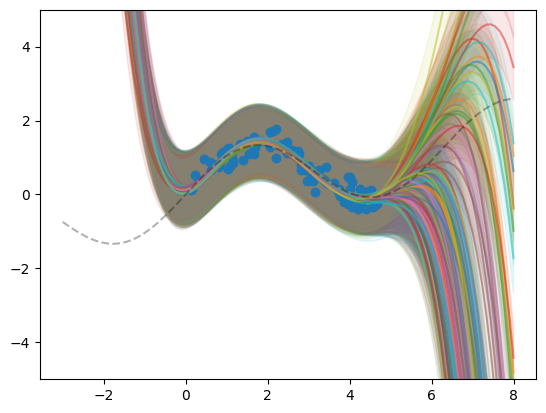

In [52]:
predictive = numpyro.infer.Predictive(
    model,
    posterior_samples=samples,
    return_sites=["y_mean", "y", "beta"],
)
pred_samples = predictive(random.PRNGKey(3), linspace)
samples_to_plot = 100
for i in range(samples_to_plot):
    plt.plot(linspace, pred_samples["y_mean"][i], color=f"C{i}", alpha=0.5)
    variance = 1 / pred_samples["beta"][i]
    lower = pred_samples["y_mean"][i] - 1.96 * jnp.sqrt(variance)
    upper = pred_samples["y_mean"][i] + 1.96 * jnp.sqrt(variance)
    plt.fill_between(
        linspace,
        lower,
        upper,
        color=f"C{i}",
        alpha=0.1,
        label="95% HDI" if i == 0 else None,
    )
plt.scatter(x, y)
plt.ylim(-5,5)
plt.plot(linspace, true_function(linspace), "--", color="black", alpha=0.3, label="True function")

Text(0.5, 1.0, 'Contour Plot of Log-Likelihood')

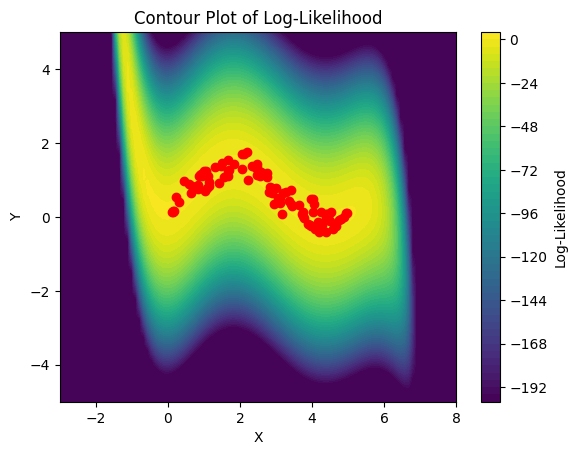

In [77]:
X_BOUNDS = [-3, 8]
Y_BOUNDS = [-5, 5]
X_linspace = jnp.linspace(X_BOUNDS[0], X_BOUNDS[1], 100)
Y_linspace = jnp.linspace(Y_BOUNDS[0], Y_BOUNDS[1], 100)
meshgrid = jnp.meshgrid(X_linspace, Y_linspace)
z_grid = []
for i, (x_grid, y_grid) in enumerate(zip(*meshgrid)):
    z_grid.append(numpyro.infer.log_likelihood(model, posterior_samples=samples, x=x_grid, y=y_grid)["y"].mean(axis=0))
z_values = jnp.array(z_grid).reshape(len(X_linspace), len(Y_linspace))
plt.contourf(X_linspace, Y_linspace, jnp.clip(z_values, min=-200), levels=50, cmap="viridis")
plt.colorbar(label="Log-Likelihood")
plt.scatter(x, y, color="red", label="Data")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Contour Plot of Log-Likelihood")